# K-Means

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
from sklearn.cluster import KMeans
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas import read_csv
import pandas as pd
from pandas import DataFrame
from pandas import concat
import numpy as np 
from matplotlib import pyplot


class KMEANS:
    def __init__(self,path, window_width, n_clusters, train_rate):
        self.df = read_csv(path, header=0, index_col=0, parse_dates=True,squeeze=True)
        self.df = self.df.reset_index(drop=True)
        self.df.rename(columns={'anomaly':'is_anomaly'}, inplace=True)
        self.n_clusters = n_clusters
        self.window_width = window_width
        series = pd.DataFrame(self.df.iloc[:,0].values)  
        self.values = DataFrame(series.values)
        self.dataframe = concat([self.values.shift(1), self.values], axis=1)
        self.dataframe.columns = ['t', 't+1']

        self.train_size = int(len(self.values) * train_rate)

        self.train, self.test = self.dataframe.values[1:self.train_size], self.dataframe.values[self.train_size:]
        self.train_X, self.train_y = self.train[:,0], self.train[:,1]
        self.test_X, self.test_y = self.test[:,0], self.test[:,1]     
        self.create_persistence()

        X = series.values
        self.train, self.test = X[1:self.train_size], X[self.train_size:]        

    def model_persistence(self, x):
        return x
        
    def create_persistence(self):
        predictions = list()
        for x in self.test_X:
            yhat = self.model_persistence(x)
            predictions.append(yhat)
        rmse = sqrt(mean_squared_error(self.test_y, predictions))
#         print('Train shape', self.train_X.shape, ' - Test shape:' , self.test_X.shape)
#         print('Persistent Model RMSE: %.3f' % rmse)   

    def fit(self):
        self.create_sequence_vectors()
        self.cluster()
        self.computeErrorValues()

    def create_sequence_vectors(self):
        self.vectors = np.array([])
        for i,_ in enumerate(self.test[:-self.window_width+1]):

            if i==0:
                self.vectors =self.test[i:i+self.window_width].reshape(1,-1)
                continue
            # np.append(self.test[i:i+self.window_width], axis=0)
            self.vectors = np.append(self.vectors,self.test[i:i+self.window_width].reshape(1,-1),axis=0)


    def cluster(self):
        self.kmeans = KMeans(n_clusters=self.n_clusters).fit(np.array(self.vectors))
        self.vector_dist = []
        for i,_ in enumerate(self.vectors):
            min_dist = float("inf")
            for cluster in self.kmeans.cluster_centers_:
                dist = np.linalg.norm(self.vectors[i]-cluster)
                if min_dist> dist:
                    min_dist = dist
            self.vector_dist.append(min_dist)

    def computeErrorValues(self):
        self.errors = np.zeros_like(self.test)
        for i,_ in enumerate(self.test):
            start_index = max(0,i-self.window_width+1)
            end_index = min(len(self.vectors), i+self.window_width)
            self.errors[i] = np.mean(np.array(self.vector_dist[start_index:end_index]))


    def plot(self):
        # plot predicted error
        pyplot.figure(figsize=(50,5))
        pyplot.plot(self.test)
        # pyplot.plot(self.predictions, color='red')
        pyplot.plot(self.errors, color = 'yellow')
        pyplot.show()

    def get_roc_auc(self,verbose = True, plot=True):
        # get the predicted errors of the anomaly points
        indices = self.df[self.df['is_anomaly']==1].index >self.train_size
        true_anomaly_predicted_errors = self.errors[self.df[self.df['is_anomaly']==1].index[indices] - self.train_size ]
        if len(true_anomaly_predicted_errors) == 0:
            return np.nan
        # sort them 
        true_anomaly_predicted_errors = np.sort(true_anomaly_predicted_errors,axis=0).reshape(-1)
        true_anomaly_predicted_errors_extended = np.r_[np.linspace(0,true_anomaly_predicted_errors[0],40)[:-1],true_anomaly_predicted_errors]
                # now iterate thru the predicted errors from small to big
        # for each value look how much other points have equal or bigger error
        FPR = [] # fp/n  https://en.wikipedia.org/wiki/Sensitivity_and_specificity
        TPR = [] # tp/p
        p = len(true_anomaly_predicted_errors)
        Thresholds = []
        for predictederror in true_anomaly_predicted_errors_extended:
            threshold = predictederror
            tp = len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>= threshold])
            fp = len(self.errors[self.errors>=threshold])-len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>=threshold])

            fpr =fp/len(self.errors)
            FPR.append(fpr)
            TPR.append(tp/p)
            if verbose:
                print("Threshold: {0:25}  - FP: {1:4} - TP: {2:4} - FPR: {3:21} - TPR: {4:4}".format(threshold,fp, tp, fpr, tp/p))

        import matplotlib.pyplot as plt
        if plot:
            plt.figure()
            plt.axis([0, 1, 0, 1])
            plt.plot(FPR,TPR)
            plt.show() 

        # This is the AUC
        from sklearn.metrics import auc
        print('AUC: ' ,auc(FPR,TPR)        )
        return auc(FPR,TPR)

# kmeans = KMEANS('Univariate/YahooServiceNetworkTraffic/A2Benchmark/synthetic_45.csv',30,4,0.3)
# kmeans.fit()
# kmeans.plot()
# kmeans.get_roc_auc(verbose=False)

## Evaluation

### Results for UD1 - UD4

In [2]:
import os
import datetime

startTime = datetime.datetime.now()
dfs = [pd.DataFrame(columns=['filename', 'auc']), pd.DataFrame(columns=['filename', 'auc']),pd.DataFrame(columns=['filename', 'auc']),pd.DataFrame(columns=['filename', 'auc'])]
files = []
import glob
folders = ['A1Benchmark','A2Benchmark','A3Benchmark','A4Benchmark']
for j,folder in enumerate(folders):
    for i,file in enumerate(glob.glob('Univariate/YahooServiceNetworkTraffic/'+ folder + '/*.csv')):
        print(file,end=' - ')
        kmeans = KMEANS( file, 30,4,0.3)
        kmeans.fit()
        dfs[j].loc[i] = [os.path.basename(file),kmeans.get_roc_auc(plot=False,verbose=False)]






# cnn.get_roc_auc(plot=False,verbose=False)

        
endTime = datetime.datetime.now()
diff = endTime - startTime
print('Time: ',diff)        

Time:  0:00:01.994550


In [3]:
print(dfs[0].describe())
print(dfs[1].describe())
print(dfs[2].describe())
print(dfs[3].describe())

             auc
count  59.000000
mean    0.877623
std     0.183512
min     0.027111
25%     0.858460
50%     0.947877
75%     0.981198
max     0.999022
              auc
count  100.000000
mean     0.923446
std      0.106158
min      0.338693
25%      0.934227
50%      0.946964
75%      0.964730
max      0.998995
             auc
count  99.000000
mean    0.728037
std     0.161099
min     0.022959
25%     0.661889
50%     0.735450
75%     0.843732
max     0.988946
             auc
count  98.000000
mean    0.663028
std     0.177332
min     0.156463
25%     0.559787
50%     0.662521
75%     0.783270
max     0.996599


# DBSCAN


In [4]:
from sklearn.cluster import KMeans
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas import read_csv
import pandas as pd
from pandas import DataFrame
from pandas import concat
import numpy as np 
from matplotlib import pyplot
from sklearn.cluster import DBSCAN
from sklearn import preprocessing

class DBSCAN_Compact:
    def __init__(self,path, window_width, eps, min_samples, train_rate):
        self.df = read_csv(path, header=0, index_col=0, parse_dates=True,squeeze=True)
        self.df = self.df.reset_index(drop=True)
        self.df.rename(columns={'anomaly':'is_anomaly'}, inplace=True)
        self.eps = eps
        self.min_samples = min_samples
        self.window_width = window_width
        series = pd.DataFrame(self.df.iloc[:,0].values)  
        self.values = DataFrame(series.values)
        self.dataframe = concat([self.values.shift(1), self.values], axis=1)
        self.dataframe.columns = ['t', 't+1']

        self.train_size = int(len(self.values) * train_rate)

        # train_labeled, test_labeled = self.dataframe.values[1:self.train_size], self.dataframe.values[self.train_size:]
        # self.train_X, self.train_y = train_labeled[:,0], train_labeled[:,1]
        # self.test_X, self.test_y = test_labeled[:,0], test_labeled[:,1]     
        # self.create_persistence()

        # X = series.values
        # self.train, self.test = X[1:self.train_size], X[self.train_size:]    

    def __build_sets(self):
        train_labeled, test_labeled = self.dataframe.values[1:self.train_size], self.dataframe.values[self.train_size:]
        self.train_X, self.train_y = train_labeled[:,0], train_labeled[:,1]
        self.test_X, self.test_y = test_labeled[:,0], test_labeled[:,1]   

        X = self.dataframe.iloc[:,1].values
        self.train, self.test = X[1:self.train_size], X[self.train_size:]    

    def standardize_dataframe(self):
        X = self.dataframe.values
        self.scalar = preprocessing.StandardScaler().fit(X)
        X = self.scalar.transform(X)
        self.dataframe = pd.DataFrame(X)

    def inverse_standardize_dataframe(self):
        X = self.dataframe.values
        X = self.scalar.inverse_transform(X)
        self.dataframe = pd.DataFrame(X)



    def model_persistence(self, x):
        return x
        
    def create_persistence(self):
        rmse = sqrt(mean_squared_error(self.dataframe['t'].iloc[self.train_size:], self.dataframe['t+1'].iloc[self.train_size::]))
#         print('Persistent Model RMSE: %.3f' % rmse)   

    def fit(self):
        self.create_persistence()
        self.standardize_dataframe()
        self.__build_sets()
                
        self.compute_anomalyScores()
        self.inverse_standardize_dataframe()
        
    def compute_anomalyScores(self):
        self.errors = np.zeros_like(self.test)
        # compute anomalies
        for i,_ in enumerate(self.test[:-self.window_width+1]):
            window = self.test[i:i+self.window_width]
            window2D = np.zeros((len(window),2))
            window2D[:,1] = window
            error = DBSCAN(self.eps, self.min_samples).fit_predict(window2D)
            error[error>0] = 0
            error*=-1
            self.errors[i:i+self.window_width] += error

        # normalize anomaly score
        self.errors[:-self.window_width+1] /= self.window_width
        for i,error in enumerate(self.test[-self.window_width+1:]):
            self.errors[-self.window_width + 1 + i] /=self.window_width-(i+1)


    def plot(self):
        # plot predicted error
        pyplot.figure(figsize=(50,5))
        pyplot.plot(self.test)
        # pyplot.plot(self.predictions, color='red')
        pyplot.plot(self.errors, color = 'red',  linewidth=0.5)
        pyplot.show()

    def get_roc_auc(self, plot=True, verbose=True):
        # get the predicted errors of the anomaly points
        indices = self.df[self.df['is_anomaly']==1].index >self.train_size
        true_anomaly_predicted_errors = self.errors[self.df[self.df['is_anomaly']==1].index[indices] - self.train_size ]
        if len(true_anomaly_predicted_errors) == 0:
            return np.nan
        # sort them 
        true_anomaly_predicted_errors = np.sort(true_anomaly_predicted_errors,axis=0).reshape(-1)
        true_anomaly_predicted_errors_extended = np.r_[np.linspace(0,true_anomaly_predicted_errors[0],40)[:-1],true_anomaly_predicted_errors]
        true_anomaly_predicted_errors_extended = np.r_[true_anomaly_predicted_errors_extended, true_anomaly_predicted_errors_extended[-1] + np.mean(true_anomaly_predicted_errors_extended)]
                # now iterate thru the predicted errors from small to big
        # for each value look how much other points have equal or bigger error
        FPR = [] # fp/n  https://en.wikipedia.org/wiki/Sensitivity_and_specificity
        TPR = [] # tp/p
        p = len(true_anomaly_predicted_errors)
        Thresholds = []
        for predictederror in true_anomaly_predicted_errors_extended:
            threshold = predictederror
            tp = len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>= threshold])
            fp = len(self.errors[self.errors>=threshold])-len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>=threshold])
            
            fpr =fp/len(self.errors)
            FPR.append(fpr)
            TPR.append(tp/p)
            if verbose:
                print("Threshold: {0:25}  - FP: {1:4} - TP: {2:4} - FPR: {3:21} - TPR: {4:4}".format(threshold,fp, tp, fpr, tp/p))

        import matplotlib.pyplot as plt
        if plot:
            plt.figure()
            plt.axis([0, 1, 0, 1])
            plt.plot(FPR,TPR)
            plt.show() 

        # This is the AUC
        from sklearn.metrics import auc
        print('AUC: ' ,auc(FPR,TPR)        )
        return auc(FPR,TPR)

# dbscan = DBSCAN_Compact('Univariate/YahooServiceNetworkTraffic/A2Benchmark/synthetic_45.csv',30,0.4,5,0.66)
# dbscan.fit()
# dbscan.plot()
# dbscan.get_roc_auc(verbose=False)

## Evaluation

### Results for UD1 - UD4

In [5]:
import os
import datetime

startTime = datetime.datetime.now()

import glob
dfs = [pd.DataFrame(columns=['filename', 'auc']), pd.DataFrame(columns=['filename', 'auc']),pd.DataFrame(columns=['filename', 'auc']),pd.DataFrame(columns=['filename', 'auc'])]
files = []
import glob
folders = ['A1Benchmark','A2Benchmark','A3Benchmark','A4Benchmark']
for j,folder in enumerate(folders):
    for i,file in enumerate(glob.glob('Univariate/YahooServiceNetworkTraffic/'+ folder + '/*.csv')):
        print(file,end=' - ')
        dbscan = DBSCAN_Compact( file, 30,0.4,5,0.3)
        dbscan.fit()
        dfs[j].loc[i] = [os.path.basename(file),dbscan.get_roc_auc(plot=False,verbose=False)]

        
endTime = datetime.datetime.now()
diff = endTime - startTime
print('Time: ',diff)               

AUC:  0.4793804021535483
Time:  0:00:08.465314


In [6]:
print(dfs[0].describe())
print(dfs[1].describe())
print(dfs[2].describe())
print(dfs[3].describe())

             auc
count  59.000000
mean    0.806574
std     0.235681
min     0.000000
25%     0.637345
50%     0.922291
75%     0.985443
max     0.997556
              auc
count  100.000000
mean     0.995251
std      0.003276
min      0.990452
25%      0.990955
50%      0.995980
75%      0.998995
max      0.998995
             auc
count  99.000000
mean    0.696868
std     0.321341
min     0.000000
25%     0.639031
50%     0.810529
75%     0.911990
max     0.999150
             auc
count  98.000000
mean    0.725566
std     0.276354
min     0.000000
25%     0.674977
50%     0.785785
75%     0.891005
max     0.999150


# LOF


In [7]:
import warnings
from sklearn.cluster import KMeans
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas import read_csv
import pandas as pd
from pandas import DataFrame
from pandas import concat
import numpy as np 
from matplotlib import pyplot
from sklearn.neighbors import LocalOutlierFactor
from sklearn import preprocessing

class LOF_Compact:
    def __init__(self,path, window_width, n_neighbors, train_rate):
        self.df = read_csv(path, header=0, index_col=0, parse_dates=True,squeeze=True)
        self.df = self.df.reset_index(drop=True)
        self.df.rename(columns={'anomaly':'is_anomaly'}, inplace=True)
        self.n_neighbors = n_neighbors
        self.window_width = window_width
        series = pd.DataFrame(self.df.iloc[:,0].values)  
        self.values = DataFrame(series.values)
        self.dataframe = concat([self.values.shift(1), self.values], axis=1)
        self.dataframe.columns = ['t', 't+1']

        self.train_size = int(len(self.values) * train_rate)

        # train_labeled, test_labeled = self.dataframe.values[1:self.train_size], self.dataframe.values[self.train_size:]
        # self.train_X, self.train_y = train_labeled[:,0], train_labeled[:,1]
        # self.test_X, self.test_y = test_labeled[:,0], test_labeled[:,1]     
        # self.create_persistence()

        # X = series.values
        # self.train, self.test = X[1:self.train_size], X[self.train_size:]    

    def __build_sets(self):
        train_labeled, test_labeled = self.dataframe.values[1:self.train_size], self.dataframe.values[self.train_size:]
        self.train_X, self.train_y = train_labeled[:,0], train_labeled[:,1]
        self.test_X, self.test_y = test_labeled[:,0], test_labeled[:,1]   

        X = self.dataframe.iloc[:,1].values
        self.train, self.test = X[1:self.train_size], X[self.train_size:]    

    def standardize_dataframe(self):
        X = self.dataframe.values
        self.scalar = preprocessing.StandardScaler().fit(X)
        X = self.scalar.transform(X)
        self.dataframe = pd.DataFrame(X)

    def inverse_standardize_dataframe(self):
        X = self.dataframe.values
        X = self.scalar.inverse_transform(X)
        self.dataframe = pd.DataFrame(X)



    def model_persistence(self, x):
        return x
        
    def create_persistence(self):
        rmse = sqrt(mean_squared_error(self.dataframe['t'].iloc[self.train_size:], self.dataframe['t+1'].iloc[self.train_size::]))
#         print('Persistent Model RMSE: %.3f' % rmse)   

    def fit(self):
        self.create_persistence()
        self.standardize_dataframe()
        self.__build_sets()
                
        self.compute_anomalyScores()
        self.inverse_standardize_dataframe()
        
    def compute_anomalyScores(self):
        self.errors = np.zeros_like(self.test)
        # compute anomalies
        warnings.filterwarnings("ignore")

        for i,_ in enumerate(self.test[:-self.window_width+1]):
            window = self.test[i:i+self.window_width]
            window2D = np.zeros((len(window),2))
            window2D[:,1] = window
            clf = LocalOutlierFactor(self.n_neighbors,contamination ='auto')
            clf.fit_predict(window2D)
            error = clf.negative_outlier_factor_ 
            error=(error*-1) - 1
            self.errors[i:i+self.window_width] += error


        # normalize anomaly score
        self.errors[:-self.window_width+1] /= self.window_width
        for i,error in enumerate(self.test[-self.window_width+1:]):
            self.errors[-self.window_width + 1 + i] /=self.window_width-(i+1)

        scalar = preprocessing.MinMaxScaler((0,1)).fit(self.errors.reshape(-1,1))
        self.errors = scalar.transform(self.errors.reshape(-1,1))*10


    def plot(self):
        # plot predicted error
        pyplot.figure(figsize=(50,5))
        pyplot.plot(self.test)
        # pyplot.plot(self.predictions, color='red')
        pyplot.plot(self.errors, color = 'red',  linewidth=0.5)
        pyplot.show()

    def get_roc_auc(self, plot=True, verbose=True):
        # get the predicted errors of the anomaly points
        indices = self.df[self.df['is_anomaly']==1].index >self.train_size
        true_anomaly_predicted_errors = self.errors[self.df[self.df['is_anomaly']==1].index[indices] - self.train_size ]
        if len(true_anomaly_predicted_errors) == 0:
            return np.nan
        # sort them 
        true_anomaly_predicted_errors = np.sort(true_anomaly_predicted_errors,axis=0).reshape(-1)
        true_anomaly_predicted_errors_extended = np.r_[np.linspace(0,true_anomaly_predicted_errors[0],40)[:-1],true_anomaly_predicted_errors]
        true_anomaly_predicted_errors_extended = np.r_[true_anomaly_predicted_errors_extended, true_anomaly_predicted_errors_extended[-1] + np.mean(true_anomaly_predicted_errors_extended)]
                # now iterate thru the predicted errors from small to big
        # for each value look how much other points have equal or bigger error
        FPR = [] # fp/n  https://en.wikipedia.org/wiki/Sensitivity_and_specificity
        TPR = [] # tp/p
        p = len(true_anomaly_predicted_errors)
        Thresholds = []
        for predictederror in true_anomaly_predicted_errors_extended:
            threshold = predictederror
            tp = len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>= threshold])
            fp = len(self.errors[self.errors>=threshold])-len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>=threshold])
            
            fpr =fp/len(self.errors)
            FPR.append(fpr)
            TPR.append(tp/p)
            if verbose:
                print("Threshold: {0:25}  - FP: {1:4} - TP: {2:4} - FPR: {3:21} - TPR: {4:4}".format(threshold,fp, tp, fpr, tp/p))

        import matplotlib.pyplot as plt
        if plot:
            plt.figure()
            plt.axis([0, 1, 0, 1])
            plt.plot(FPR,TPR)
            plt.show() 

        # This is the AUC
        from sklearn.metrics import auc
        print('AUC: ' ,auc(FPR,TPR)        )
        return auc(FPR,TPR)
    
lof = LOF_Compact('Univariate/YahooServiceNetworkTraffic/A2Benchmark/synthetic_45.csv',30,10,0.66)
lof.fit()
lof.plot()
lof.get_roc_auc(verbose=False)

FileNotFoundError: ignored

## Evaluation

### Results for UD1 - UD4

In [8]:
import os
import datetime

startTime = datetime.datetime.now()

import glob
dfs = [pd.DataFrame(columns=['filename', 'auc']), pd.DataFrame(columns=['filename', 'auc']),pd.DataFrame(columns=['filename', 'auc']),pd.DataFrame(columns=['filename', 'auc'])]
files = []
import glob
folders = ['A1Benchmark','A2Benchmark','A3Benchmark','A4Benchmark']
for j,folder in enumerate(folders):
    for i,file in enumerate(glob.glob('Univariate/YahooServiceNetworkTraffic/'+ folder + '/*.csv')):
        print(file,end=' - ')
        lof = LOF_Compact( file, 30,10,0.3)
        lof.fit()
        dfs[j].loc[i] = [os.path.basename(file),lof.get_roc_auc(plot=False,verbose=False)]



cnn = LOF_Compact( 'drive/My Drive/MT/Experiments/Univariate/NYC_Taxi/nyc_taxi.csv',  20,5,0.3)
cnn.fit()
cnn.get_roc_auc(plot=False,verbose=False)

        
endTime = datetime.datetime.now()
diff = endTime - startTime
print('Time: ',diff)     

AUC:  0.5294685081872444
Time:  0:00:05.656312


In [9]:
print(dfs[0].describe())
print(dfs[1].describe())
print(dfs[2].describe())
print(dfs[3].describe())

             auc
count  59.000000
mean    0.814574
std     0.202920
min     0.370296
25%     0.628991
50%     0.945517
75%     0.988554
max     0.999022
              auc
count  100.000000
mean     0.995116
std      0.003484
min      0.984925
25%      0.990955
50%      0.995980
75%      0.998995
max      0.998995
             auc
count  99.000000
mean    0.951007
std     0.058915
min     0.656037
25%     0.942971
50%     0.967626
75%     0.991277
max     0.999150
             auc
count  98.000000
mean    0.952523
std     0.055031
min     0.694940
25%     0.930082
50%     0.972913
75%     0.994792
max     0.999150


# Isolation Forest

In [10]:
import warnings
from sklearn.cluster import KMeans
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas import read_csv
import pandas as pd
from pandas import DataFrame
from pandas import concat
import numpy as np 
from matplotlib import pyplot
from sklearn.ensemble import IsolationForest 
from sklearn import preprocessing
import sys

class IForest:
    def __init__(self,path, window_width, n_estimators, contamination, train_rate):
        self.df = read_csv(path, header=0, index_col=0, parse_dates=True,squeeze=True)
        self.df = self.df.reset_index(drop=True)
        self.df.rename(columns={'anomaly':'is_anomaly'}, inplace=True)
        self.n_estimators = n_estimators
        self.contamination = contamination
        self.window_width = window_width
        series = pd.DataFrame(self.df.iloc[:,0].values)  
        self.values = DataFrame(series.values)
        self.dataframe = concat([self.values.shift(1), self.values], axis=1)
        self.dataframe.columns = ['t', 't+1']

        self.train_size = int(len(self.values) * train_rate)

        # train_labeled, test_labeled = self.dataframe.values[1:self.train_size], self.dataframe.values[self.train_size:]
        # self.train_X, self.train_y = train_labeled[:,0], train_labeled[:,1]
        # self.test_X, self.test_y = test_labeled[:,0], test_labeled[:,1]     
        # self.create_persistence()

        # X = series.values
        # self.train, self.test = X[1:self.train_size], X[self.train_size:]    

    def __build_sets(self):
        train_labeled, test_labeled = self.dataframe.values[1:self.train_size], self.dataframe.values[self.train_size:]
        self.train_X, self.train_y = train_labeled[:,0], train_labeled[:,1]
        self.test_X, self.test_y = test_labeled[:,0], test_labeled[:,1]   

        X = self.dataframe.iloc[:,1].values
        self.train, self.test = X[1:self.train_size], X[self.train_size:]    

    def standardize_dataframe(self):
        X = self.dataframe.values
        self.scalar = preprocessing.StandardScaler().fit(X)
        X = self.scalar.transform(X)
        self.dataframe = pd.DataFrame(X)

    def inverse_standardize_dataframe(self):
        X = self.dataframe.values
        X = self.scalar.inverse_transform(X)
        self.dataframe = pd.DataFrame(X)



    def model_persistence(self, x):
        return x
        
    def create_persistence(self):
        rmse = sqrt(mean_squared_error(self.dataframe['t'].iloc[self.train_size:], self.dataframe['t+1'].iloc[self.train_size::]))
#         print('Persistent Model RMSE: %.3f' % rmse)   

    def fit(self):
        self.create_persistence()
        self.standardize_dataframe()
        self.__build_sets()
                
        self.compute_anomalyScores()
        self.inverse_standardize_dataframe()
    
    def getWindowedVectors(self, X):
        vectors = []
        for i,_ in enumerate(X[:-self.window_width+1]):
            vectors.append(X[i:i+self.window_width])
        return vectors

    def compute_anomalyScores(self):
        self.errors = np.zeros_like(self.test)
        # compute anomalies
        warnings.filterwarnings("ignore")

        # history = self.getWindowedVectors(self.train)

        for i,_ in enumerate(self.test[:-self.window_width+1]):
            sys.stdout.write('\r'+str(i)+':'+str(len(self.test) - self.window_width))

            window = self.test[i:i+self.window_width]
            window2D = np.zeros((len(window),2))
            window2D[:,1] = window
            clf=IsolationForest(n_estimators=self.n_estimators,   # number of isolation trees
                            max_samples='auto', # number of samples to draw to create an isolation tree
                            contamination=self.contamination, # porportion of outliers
                            max_features=1.0,   #
                            bootstrap=False, 
                            n_jobs=-1, 
                            random_state=42, 
                            verbose=0, behaviour='new')
            clf.fit(window2D)
            error = clf.decision_function(window2D) 
            error[error>0] = 0
            self.errors[i:i+self.window_width] += error*-1


        # normalize anomaly score
        self.errors[:-self.window_width+1] /= self.window_width
        for i,error in enumerate(self.test[-self.window_width+1:]):
            self.errors[-self.window_width + 1 + i] /=self.window_width-(i+1)

        self.errors_original = self.errors
        scalar = preprocessing.MinMaxScaler((0,1)).fit(self.errors.reshape(-1,1))
        self.errors = scalar.transform(self.errors.reshape(-1,1))*10


    def plot(self):
        # plot predicted error
        pyplot.figure(figsize=(50,5))
        pyplot.plot(self.test)
        # pyplot.plot(self.predictions, color='red')
        pyplot.plot(self.errors, color = 'red',  linewidth=0.5)
        pyplot.show()

    def get_roc_auc(self, plot=True, verbose=True):
        # get the predicted errors of the anomaly points
        indices = self.df[self.df['is_anomaly']==1].index >self.train_size
        true_anomaly_predicted_errors = self.errors[self.df[self.df['is_anomaly']==1].index[indices] - self.train_size ]
        if len(true_anomaly_predicted_errors) == 0:
            return np.nan

        # sort them 
        true_anomaly_predicted_errors = np.sort(true_anomaly_predicted_errors,axis=0).reshape(-1)
        true_anomaly_predicted_errors_extended = np.r_[np.linspace(0,true_anomaly_predicted_errors[0],40)[:-1],true_anomaly_predicted_errors]
        true_anomaly_predicted_errors_extended = np.r_[true_anomaly_predicted_errors_extended, true_anomaly_predicted_errors_extended[-1] + np.mean(true_anomaly_predicted_errors_extended)]
                # now iterate thru the predicted errors from small to big
        # for each value look how much other points have equal or bigger error
        FPR = [] # fp/n  https://en.wikipedia.org/wiki/Sensitivity_and_specificity
        TPR = [] # tp/p
        p = len(true_anomaly_predicted_errors)
        Thresholds = []
        for predictederror in true_anomaly_predicted_errors_extended:
            threshold = predictederror
            tp = len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>= threshold])
            fp = len(self.errors[self.errors>=threshold])-len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>=threshold])
            
            fpr =fp/len(self.errors)
            FPR.append(fpr)
            TPR.append(tp/p)
            if verbose:
                print("Threshold: {0:25}  - FP: {1:4} - TP: {2:4} - FPR: {3:21} - TPR: {4:4}".format(threshold,fp, tp, fpr, tp/p))

        import matplotlib.pyplot as plt
        if plot:
            plt.figure()
            plt.axis([0, 1, 0, 1])
            plt.plot(FPR,TPR)
            plt.show() 

        # This is the AUC
        from sklearn.metrics import auc
        print('AUC: ' ,auc(FPR,TPR)        )
        return auc(FPR,TPR)

# iforest = IForest('Univariate/YahooServiceNetworkTraffic/A2Benchmark/synthetic_45.csv',30,10,'auto',0.66)
# iforest.fit()
# iforest.plot()
# iforest.get_roc_auc(verbose=False)

## Evaluation

### Results for UD1 - UD4

In [11]:
import os
dfs = [pd.DataFrame(columns=['filename', 'auc']), pd.DataFrame(columns=['filename', 'auc']),pd.DataFrame(columns=['filename', 'auc']),pd.DataFrame(columns=['filename', 'auc'])]
files = []
import glob
folders = ['A1Benchmark','A2Benchmark','A3Benchmark','A4Benchmark']
for j,folder in enumerate(folders):
    for i,file in enumerate(glob.glob('Univariate/YahooServiceNetworkTraffic/'+ folder + '/*.csv')):
        print(file,end=' - ')
        iforest = IForest( file, 30,10, 'auto',0.3)
        iforest.fit()
        dfs[j].loc[i] = [os.path.basename(file),iforest.get_roc_auc(plot=False,verbose=False)]

964:964ate/YahooServiceNetworkTraffic/A1Benchmark\real_1.csv - AUC:  0.9914486921529174
978:978AUC:  0.7664072039072038raffic/A1Benchmark\real_10.csv - 
978:978ate/YahooServiceNetworkTraffic/A1Benchmark\real_11.csv - AUC:  0.8007518796992482
978:978AUC:  0.9975198412698412raffic/A1Benchmark\real_12.csv - 
978:978ate/YahooServiceNetworkTraffic/A1Benchmark\real_13.csv - AUC:  0.9269731040564373
978:978ate/YahooServiceNetworkTraffic/A1Benchmark\real_14.csv - Univariate/YahooServiceNetworkTraffic/A1Benchmark\real_15.csv - AUC:  0.9733382936507936
993:993ate/YahooServiceNetworkTraffic/A1Benchmark\real_16.csv - AUC:  0.9931573802541545
967:967AUC:  0.45584330082759283affic/A1Benchmark\real_17.csv - 
967:967AUC:  0.3947149819502561etworkTraffic/A1Benchmark\real_19.csv - 
978:978AUC:  0.9189608134920635raffic/A1Benchmark\real_2.csv - 
966:966AUC:  0.7049409760253134raffic/A1Benchmark\real_20.csv - 
964:964ate/YahooServiceNetworkTraffic/A1Benchmark\real_21.csv - AUC:  0.9751844399731724
964:964

965:965AUC:  0.9937185929648241raffic/A2Benchmark\synthetic_46.csv - 
965:965AUC:  0.9895589056393077raffic/A2Benchmark\synthetic_47.csv - 
965:965AUC:  0.9989949748743718raffic/A2Benchmark\synthetic_48.csv - 
965:965AUC:  0.9959798994974876raffic/A2Benchmark\synthetic_49.csv - 
965:965ate/YahooServiceNetworkTraffic/A2Benchmark\synthetic_5.csv - AUC:  0.990898939140145
965:965ate/YahooServiceNetworkTraffic/A2Benchmark\synthetic_50.csv - AUC:  0.9865996649916248
965:965ate/YahooServiceNetworkTraffic/A2Benchmark\synthetic_51.csv - AUC:  0.9989949748743717
965:965ate/YahooServiceNetworkTraffic/A2Benchmark\synthetic_52.csv - AUC:  0.9939698492462312
965:965ate/YahooServiceNetworkTraffic/A2Benchmark\synthetic_53.csv - AUC:  0.9878838637632608
965:965ate/YahooServiceNetworkTraffic/A2Benchmark\synthetic_54.csv - AUC:  0.9969849246231155
965:965ate/YahooServiceNetworkTraffic/A2Benchmark\synthetic_55.csv - AUC:  0.9951005025125629
965:965ate/YahooServiceNetworkTraffic/A2Benchmark\synthetic_56.c

1146:1146AUC:  0.955498866213152affic/A3Benchmark\A3Benchmark-TS4.csv - 
1146:1146e/YahooServiceNetworkTraffic/A3Benchmark\A3Benchmark-TS40.csv - AUC:  0.9852607709750567
1146:1146AUC:  0.8995181405895691ffic/A3Benchmark\A3Benchmark-TS41.csv - 
1146:1146AUC:  0.8931547619047618ffic/A3Benchmark\A3Benchmark-TS42.csv - 
1146:1146e/YahooServiceNetworkTraffic/A3Benchmark\A3Benchmark-TS43.csv - AUC:  0.8808578987150416
1146:1146AUC:  0.9395549886621315ffic/A3Benchmark\A3Benchmark-TS44.csv - 
1146:1146e/YahooServiceNetworkTraffic/A3Benchmark\A3Benchmark-TS45.csv - AUC:  0.9858843537414965
1146:1146AUC:  0.9982993197278912ffic/A3Benchmark\A3Benchmark-TS46.csv - 
1146:1146e/YahooServiceNetworkTraffic/A3Benchmark\A3Benchmark-TS47.csv - AUC:  0.9887136672850958
1146:1146AUC:  0.9459426627793975ffic/A3Benchmark\A3Benchmark-TS48.csv - 
1146:1146AUC:  0.9897534013605442ffic/A3Benchmark\A3Benchmark-TS49.csv - 
1146:1146e/YahooServiceNetworkTraffic/A3Benchmark\A3Benchmark-TS5.csv - AUC:  0.99829931972

1146:1146AUC:  0.9088718820861679ffic/A4Benchmark\A4Benchmark-TS37.csv - 
1146:1146AUC:  0.9636479591836736ffic/A4Benchmark\A4Benchmark-TS38.csv - 
1146:1146AUC:  0.9816849816849814ffic/A4Benchmark\A4Benchmark-TS39.csv - 
1146:1146AUC:  0.955498866213152affic/A4Benchmark\A4Benchmark-TS4.csv - 
1146:1146AUC:  0.9834892290249433ffic/A4Benchmark\A4Benchmark-TS40.csv - 
1146:1146AUC:  0.8928184910327769ffic/A4Benchmark\A4Benchmark-TS41.csv - 
1146:1146AUC:  0.9974489795918368ffic/A4Benchmark\A4Benchmark-TS42.csv - 
1146:1146e/YahooServiceNetworkTraffic/A4Benchmark\A4Benchmark-TS43.csv - AUC:  0.9681831065759638
1146:1146e/YahooServiceNetworkTraffic/A4Benchmark\A4Benchmark-TS44.csv - AUC:  0.9474611273080662
1146:1146AUC:  0.9662900874635569ffic/A4Benchmark\A4Benchmark-TS45.csv - 
1146:1146e/YahooServiceNetworkTraffic/A4Benchmark\A4Benchmark-TS46.csv - AUC:  0.9348958333333333
1146:1146AUC:  0.9991496598639455ffic/A4Benchmark\A4Benchmark-TS47.csv - 
1146:1146e/YahooServiceNetworkTraffic/A4B

In [12]:
print(dfs[0].describe())
print(dfs[1].describe())
print(dfs[2].describe())
print(dfs[3].describe())

             auc
count  59.000000
mean    0.803997
std     0.192913
min     0.394715
25%     0.667753
50%     0.897491
75%     0.969549
max     0.999022
              auc
count  100.000000
mean     0.993984
std      0.004887
min      0.973702
25%      0.990103
50%      0.995101
75%      0.998995
max      0.998995
             auc
count  99.000000
mean    0.952241
std     0.053783
min     0.676587
25%     0.939756
50%     0.965561
75%     0.991709
max     0.999150
             auc
count  98.000000
mean    0.955123
std     0.054891
min     0.757122
25%     0.938560
50%     0.975720
75%     0.996599
max     0.999150


# OCSVN

964:964

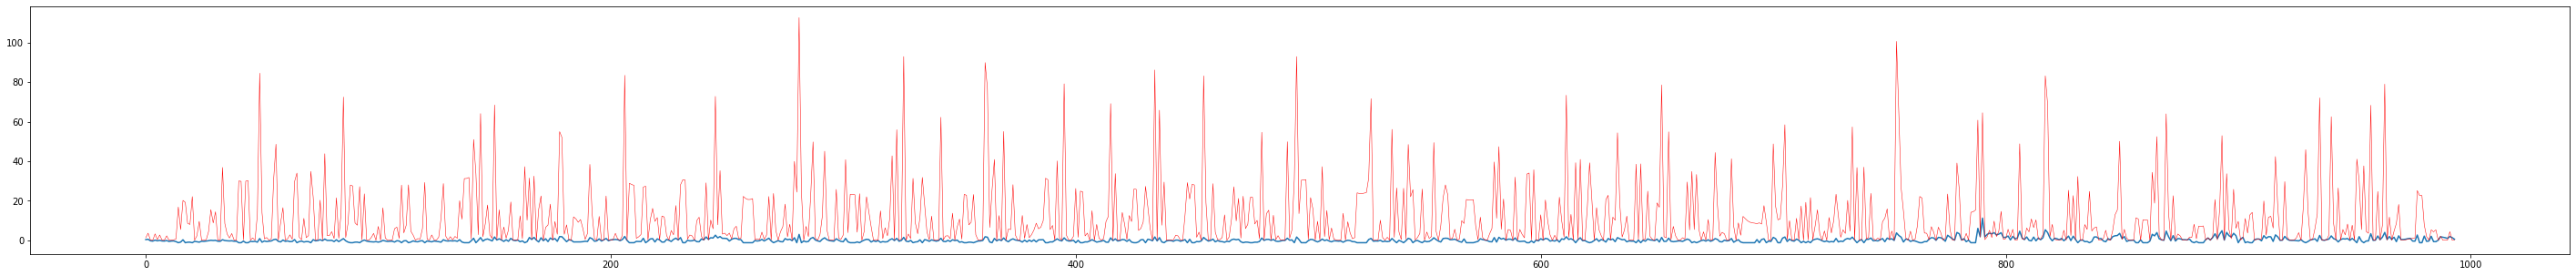

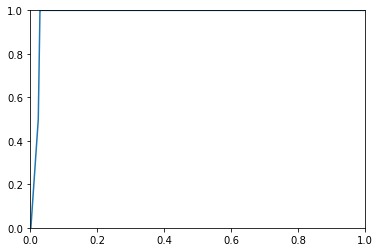

AUC:  0.9781187122736418


0.9781187122736418

In [13]:
import warnings
from sklearn.cluster import KMeans
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas import read_csv
import pandas as pd
from pandas import DataFrame
from pandas import concat
import numpy as np 
from matplotlib import pyplot
from sklearn.svm import OneClassSVM
from sklearn import preprocessing
import sys

class OneClassSVM_AnomalyDetection:
    def __init__(self,path, window_width, nu, train_rate):
        self.df = read_csv(path, header=0, index_col=0, parse_dates=True,squeeze=True)
        self.df = self.df.reset_index(drop=True)
        self.df.rename(columns={'anomaly':'is_anomaly'}, inplace=True)
        self.nu = nu
        self.window_width = window_width
        series = pd.DataFrame(self.df.iloc[:,0].values)  
        self.values = DataFrame(series.values)
        self.dataframe = concat([self.values.shift(1), self.values], axis=1)
        self.dataframe.columns = ['t', 't+1']

        self.train_size = int(len(self.values) * train_rate)

        # train_labeled, test_labeled = self.dataframe.values[1:self.train_size], self.dataframe.values[self.train_size:]
        # self.train_X, self.train_y = train_labeled[:,0], train_labeled[:,1]
        # self.test_X, self.test_y = test_labeled[:,0], test_labeled[:,1]     
        # self.create_persistence()

        # X = series.values
        # self.train, self.test = X[1:self.train_size], X[self.train_size:]    

    def __build_sets(self):
        train_labeled, test_labeled = self.dataframe.values[1:self.train_size], self.dataframe.values[self.train_size:]
        self.train_X, self.train_y = train_labeled[:,0], train_labeled[:,1]
        self.test_X, self.test_y = test_labeled[:,0], test_labeled[:,1]   

        X = self.dataframe.iloc[:,1].values
        self.train, self.test = X[1:self.train_size], X[self.train_size:]    

    def standardize_dataframe(self):
        X = self.dataframe.values
        self.scalar = preprocessing.StandardScaler().fit(X)
        X = self.scalar.transform(X)
        self.dataframe = pd.DataFrame(X)

    def inverse_standardize_dataframe(self):
        X = self.dataframe.values
        X = self.scalar.inverse_transform(X)
        self.dataframe = pd.DataFrame(X)



    def model_persistence(self, x):
        return x
        
    def create_persistence(self):
        rmse = sqrt(mean_squared_error(self.dataframe['t'].iloc[self.train_size:], self.dataframe['t+1'].iloc[self.train_size::]))
#         print('Persistent Model RMSE: %.3f' % rmse)   

    def fit(self):
        self.create_persistence()
        self.standardize_dataframe()
        self.__build_sets()
                
        self.compute_anomalyScores()
        self.inverse_standardize_dataframe()
    
    def getWindowedVectors(self, X):
        vectors = []
        for i,_ in enumerate(X[:-self.window_width+1]):
            vectors.append(X[i:i+self.window_width])
        return vectors

    def compute_anomalyScores(self):
        self.errors = np.zeros_like(self.test)
        # compute anomalies
        warnings.filterwarnings("ignore")

        # history = self.getWindowedVectors(self.train)

        for i,_ in enumerate(self.test[:-self.window_width+1]):
            sys.stdout.write('\r'+str(i)+':'+str(len(self.test) - self.window_width))

            window = self.test[i:i+self.window_width]
            window2D = np.zeros((len(window),2))
            window2D[:,1] = window
            clf=OneClassSVM(nu=self.nu)
            clf.fit(window2D)
            error = clf.decision_function(window2D) 
            error[error>0] = 0
            self.errors[i:i+self.window_width] += error*-10


        # normalize anomaly score
        self.errors[:-self.window_width+1] /= self.window_width
        for i,error in enumerate(self.test[-self.window_width+1:]):
            self.errors[-self.window_width + 1 + i] /=self.window_width-(i+1)

        # self.errors_original = self.errors
        # scalar = preprocessing.MinMaxScaler((0,1)).fit(self.errors.reshape(-1,1))
        # self.errors = scalar.transform(self.errors.reshape(-1,1))*10


    def plot(self):
        # plot predicted error
        pyplot.figure(figsize=(50,5))
        pyplot.plot(self.test)
        # pyplot.plot(self.predictions, color='red')
        pyplot.plot(self.errors, color = 'red',  linewidth=0.5)
        pyplot.show()

    def get_roc_auc(self, plot=True, verbose=True):
        # get the predicted errors of the anomaly points
        indices = self.df[self.df['is_anomaly']==1].index >self.train_size
        true_anomaly_predicted_errors = self.errors[self.df[self.df['is_anomaly']==1].index[indices] - self.train_size ]
        if len(true_anomaly_predicted_errors) == 0:
            return np.nan
        # sort them 
        true_anomaly_predicted_errors = np.sort(true_anomaly_predicted_errors,axis=0).reshape(-1)
        true_anomaly_predicted_errors_extended = np.r_[np.linspace(0,true_anomaly_predicted_errors[0],40)[:-1],true_anomaly_predicted_errors]
        true_anomaly_predicted_errors_extended = np.r_[true_anomaly_predicted_errors_extended, true_anomaly_predicted_errors_extended[-1] + np.mean(true_anomaly_predicted_errors_extended)]
                # now iterate thru the predicted errors from small to big
        # for each value look how much other points have equal or bigger error
        FPR = [] # fp/n  https://en.wikipedia.org/wiki/Sensitivity_and_specificity
        TPR = [] # tp/p
        p = len(true_anomaly_predicted_errors)
        Thresholds = []
        for predictederror in true_anomaly_predicted_errors_extended:
            threshold = predictederror
            tp = len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>= threshold])
            fp = len(self.errors[self.errors>=threshold])-len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>=threshold])
            
            fpr =fp/len(self.errors)
            FPR.append(fpr)
            TPR.append(tp/p)
            if verbose:
                print("Threshold: {0:25}  - FP: {1:4} - TP: {2:4} - FPR: {3:21} - TPR: {4:4}".format(threshold,fp, tp, fpr, tp/p))

        import matplotlib.pyplot as plt
        if plot:
            plt.figure()
            plt.axis([0, 1, 0, 1])
            plt.plot(FPR,TPR)
            plt.show() 

        # This is the AUC
        from sklearn.metrics import auc
        print('AUC: ' ,auc(FPR,TPR)        )
        return auc(FPR,TPR)
    
iforest = OneClassSVM_AnomalyDetection('Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_1.csv',30,0.7,0.3)
iforest.fit()
iforest.plot()
iforest.get_roc_auc(verbose=False)

## Evaluation

In [15]:
import os
import datetime
startTime = datetime.datetime.now()

dfs = [pd.DataFrame(columns=['filename', 'auc']), pd.DataFrame(columns=['filename', 'auc']),pd.DataFrame(columns=['filename', 'auc']),pd.DataFrame(columns=['filename', 'auc'])]
files = []
import glob
folders = ['A1Benchmark','A2Benchmark','A3Benchmark','A4Benchmark']
for j,folder in enumerate(folders):
    for i,file in enumerate(glob.glob('Univariate/YahooServiceNetworkTraffic/'+ folder + '/*.csv')):
        print(file,end=' - ')
        ocsvm = OneClassSVM_AnomalyDetection( file, 30,0.7,0.3)
        ocsvm.fit()
        dfs[j].loc[i] = [os.path.basename(file),ocsvm.get_roc_auc(plot=False,verbose=False)]
        
endTime = datetime.datetime.now()
diff = endTime - startTime
print('Time: ',diff.seconds)

964:964AUC:  0.9781187122736418raffic/A1Benchmark\real_1.csv - 
978:978AUC:  0.7187118437118437raffic/A1Benchmark\real_10.csv - 
978:978AUC:  0.9496397243107768raffic/A1Benchmark\real_11.csv - 
978:978AUC:  0.9980158730158729raffic/A1Benchmark\real_12.csv - 
978:978AUC:  0.9703483245149913raffic/A1Benchmark\real_13.csv - 
978:978AUC:  0.990451388888889NetworkTraffic/A1Benchmark\real_15.csv - 
993:993AUC:  0.997067448680352Traffic/A1Benchmark\real_16.csv - 
967:967AUC:  0.6112787702313991raffic/A1Benchmark\real_17.csv - 
967:967AUC:  0.5800706083006729etworkTraffic/A1Benchmark\real_19.csv - 
978:978AUC:  0.9841269841269841raffic/A1Benchmark\real_2.csv - 
966:966AUC:  0.9201198734331265raffic/A1Benchmark\real_20.csv - 
964:964AUC:  0.993209255533199Traffic/A1Benchmark\real_21.csv - 
964:964AUC:  0.7865047427421672raffic/A1Benchmark\real_22.csv - 
964:964AUC:  0.9790409121395036raffic/A1Benchmark\real_23.csv - 
993:993AUC:  0.7088628217660475raffic/A1Benchmark\real_24.csv - 
975:975AUC:  

965:965AUC:  0.9959798994974873raffic/A2Benchmark\synthetic_64.csv - 
965:965AUC:  0.9909547738693467raffic/A2Benchmark\synthetic_65.csv - 
965:965AUC:  0.9989949748743718raffic/A2Benchmark\synthetic_66.csv - 
965:965AUC:  0.9959798994974874raffic/A2Benchmark\synthetic_67.csv - 
965:965AUC:  0.9909547738693466raffic/A2Benchmark\synthetic_68.csv - 
965:965AUC: ahooServiceNetworkTraffic/A2Benchmark\synthetic_69.csv -  0.9989949748743718
965:965AUC:  0.9959798994974874raffic/A2Benchmark\synthetic_7.csv - 
965:965AUC:  0.9959798994974874raffic/A2Benchmark\synthetic_70.csv - 
965:965AUC:  0.9909547738693467raffic/A2Benchmark\synthetic_71.csv - 
965:965AUC:  0.9989949748743718raffic/A2Benchmark\synthetic_72.csv - 
965:965AUC:  0.9959798994974876raffic/A2Benchmark\synthetic_73.csv - 
965:965AUC:  0.9909547738693467raffic/A2Benchmark\synthetic_74.csv - 
965:965AUC:  0.9989949748743719raffic/A2Benchmark\synthetic_75.csv - 
965:965AUC:  0.9959798994974874raffic/A2Benchmark\synthetic_76.csv - 
96

1146:1146AUC:  0.9911186696900982ffic/A3Benchmark\A3Benchmark-TS75.csv - 
1146:1146AUC:  0.9965986394557822ffic/A3Benchmark\A3Benchmark-TS76.csv - 
1146:1146AUC:  0.9834183673469387ffic/A3Benchmark\A3Benchmark-TS77.csv - 
1146:1146AUC:  0.986665120593692affic/A3Benchmark\A3Benchmark-TS78.csv - 
1146:1146AUC:  0.9965986394557822ffic/A3Benchmark\A3Benchmark-TS79.csv - 
1146:1146AUC:  0.9965986394557822ffic/A3Benchmark\A3Benchmark-TS8.csv - 
1146:1146AUC:  0.9538690476190476ffic/A3Benchmark\A3Benchmark-TS80.csv - 
1146:1146AUC:  0.9701436130007559ffic/A3Benchmark\A3Benchmark-TS81.csv - 
1146:1146AUC:  0.9521379980563656ffic/A3Benchmark\A3Benchmark-TS82.csv - 
1146:1146AUC:  0.9788359788359788ffic/A3Benchmark\A3Benchmark-TS83.csv - 
1146:1146AUC:  0.9107142857142857ffic/A3Benchmark\A3Benchmark-TS84.csv - 
1146:1146AUC:  0.9602891156462584ffic/A3Benchmark\A3Benchmark-TS85.csv - 
1146:1146AUC:  0.959608843537415affic/A3Benchmark\A3Benchmark-TS86.csv - 
1146:1146AUC:  0.9047619047619048ffic/A

1146:1146AUC:  0.9380196523053665ffic/A4Benchmark\A4Benchmark-TS86.csv - 
1146:1146AUC:  0.9991496598639457ffic/A4Benchmark\A4Benchmark-TS87.csv - 
1146:1146AUC:  0.9366921768707483ffic/A4Benchmark\A4Benchmark-TS88.csv - 
1146:1146AUC:  0.9921647230320699ffic/A4Benchmark\A4Benchmark-TS89.csv - 
1146:1146AUC:  0.9991496598639455ffic/A4Benchmark\A4Benchmark-TS9.csv - 
1146:1146AUC:  0.9826287657920312ffic/A4Benchmark\A4Benchmark-TS90.csv - 
1146:1146AUC:  0.8721452866861031ffic/A4Benchmark\A4Benchmark-TS91.csv - 
1146:1146AUC:  0.9757980115122972ffic/A4Benchmark\A4Benchmark-TS92.csv - 
1146:1146AUC:  0.9974489795918368ffic/A4Benchmark\A4Benchmark-TS93.csv - 
1146:1146AUC:  0.8883692365835222ffic/A4Benchmark\A4Benchmark-TS94.csv - 
1146:1146AUC:  0.9739583333333334ffic/A4Benchmark\A4Benchmark-TS95.csv - 
1146:1146AUC:  0.9991496598639455ffic/A4Benchmark\A4Benchmark-TS96.csv - 
1146:1146AUC:  0.9325525664811379ffic/A4Benchmark\A4Benchmark-TS97.csv - 
1146:1146AUC:  0.8501039304610732ffic/A

### Results for UD1 - UD4

In [16]:
print(dfs[0].describe())
print(dfs[1].describe())
print(dfs[2].describe())
print(dfs[3].describe())

             auc
count  59.000000
mean    0.850292
std     0.210282
min     0.191341
25%     0.780710
50%     0.944333
75%     0.989205
max     0.999022
              auc
count  100.000000
mean     0.995276
std      0.003292
min      0.990452
25%      0.990955
50%      0.995980
75%      0.998995
max      0.998995
             auc
count  99.000000
mean    0.957272
std     0.052413
min     0.696003
25%     0.951990
50%     0.972045
75%     0.991348
max     0.999150
             auc
count  98.000000
mean    0.939444
std     0.063793
min     0.720982
25%     0.908677
50%     0.960945
75%     0.989046
max     0.999150


# XGBoosting

[16:29:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


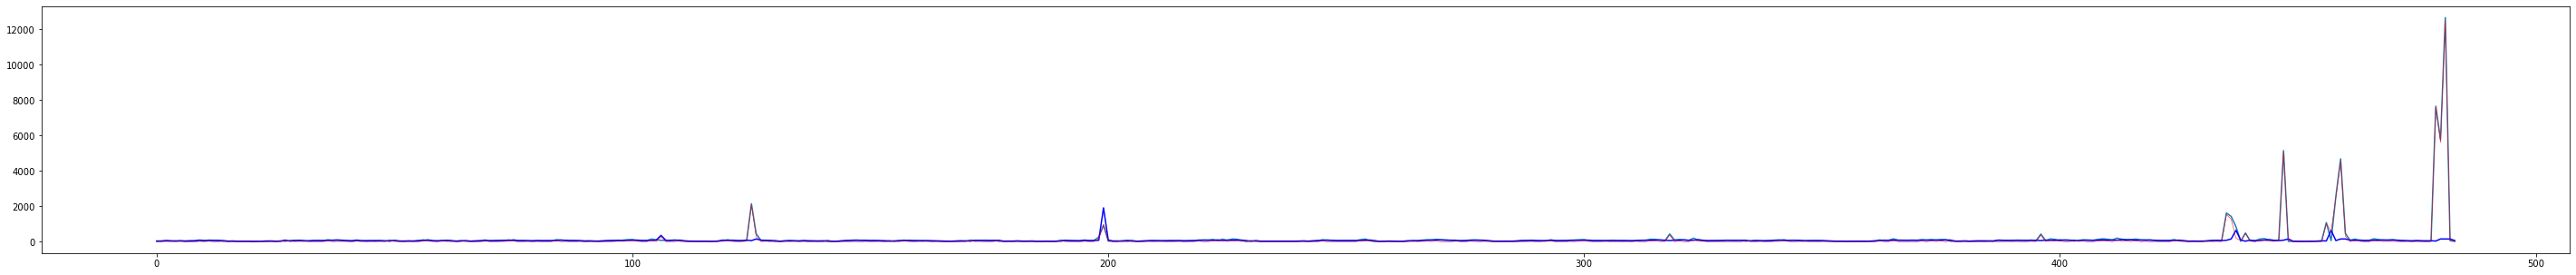

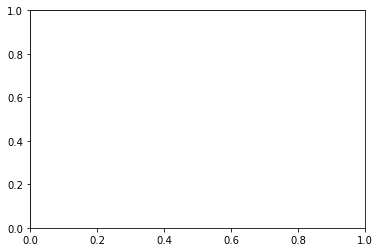

AUC:  0.9896694214876033


0.9896694214876033

In [17]:
import warnings
from sklearn.cluster import KMeans
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas import read_csv
import pandas as pd
from pandas import DataFrame
from pandas import concat
import numpy as np 
from matplotlib import pyplot
from xgboost import XGBRegressor
from sklearn import preprocessing
import sys

class XGBRegressor_AnomalyDetection:
    def __init__(self,path, window_width, nu, train_rate):
        self.df = read_csv(path, header=0, index_col=0, parse_dates=True,squeeze=True)
        self.df = self.df.reset_index(drop=True)
        self.df.rename(columns={'anomaly':'is_anomaly'}, inplace=True)
        self.nu = nu
        self.window_width = window_width
        series = pd.DataFrame(self.df.iloc[:,0].values)  
        self.values = DataFrame(series.values)
        self.dataframe = concat([self.values.shift(1), self.values], axis=1)
        self.dataframe.columns = ['t', 't+1']

        self.train_size = int(len(self.values) * train_rate)

        # train_labeled, test_labeled = self.dataframe.values[1:self.train_size], self.dataframe.values[self.train_size:]
        # self.train_X, self.train_y = train_labeled[:,0], train_labeled[:,1]
        # self.test_X, self.test_y = test_labeled[:,0], test_labeled[:,1]     
        # self.create_persistence()

        # X = series.values
        # self.train, self.test = X[1:self.train_size], X[self.train_size:]    

    def __build_sets(self):
        train_labeled, test_labeled = self.dataframe.values[1:self.train_size], self.dataframe.values[self.train_size:]
        self.train_X, self.train_y = train_labeled[:,0], train_labeled[:,1]
        self.test_X, self.test_y = test_labeled[:,0], test_labeled[:,1]   

        X = self.dataframe.iloc[:,1].values
        self.train, self.test = X[1:self.train_size], X[self.train_size:]    

    def standardize_dataframe(self):
        X = self.dataframe.values
        self.scalar = preprocessing.StandardScaler().fit(X)
        X = self.scalar.transform(X)
        self.dataframe = pd.DataFrame(X)

    def inverse_standardize_dataframe(self):
        X = self.dataframe.values
        X = self.scalar.inverse_transform(X)
        self.dataframe = pd.DataFrame(X)



    def model_persistence(self, x):
        return x
        
    def create_persistence(self):
        rmse = sqrt(mean_squared_error(self.dataframe['t'].iloc[self.train_size:], self.dataframe['t+1'].iloc[self.train_size::]))
#         print('Persistent Model RMSE: %.3f' % rmse)   

    def fit(self):
        self.create_persistence()
        self.__build_sets()
                
        self.compute_anomalyScores()
    
    def getWindowedVectors(self, X):
        vectors = []
        for i,_ in enumerate(X[:-self.window_width+1]):
            vectors.append(X[i:i+self.window_width])
        return vectors

    def compute_anomalyScores(self):

        xgb = XGBRegressor()
        xgb.fit(self.train_X.reshape(-1,1),self.train_y.reshape(-1,1))

        self.predictions = xgb.predict(self.test_X.reshape(-1,1))
        rmse = sqrt(mean_squared_error(self.test, self.predictions))
        self.errors = np.absolute(self.test - np.array(self.predictions))
#         print('Prediction Test RMSE: %.3f' % rmse)
    

    def plot(self):
        # plot predicted error
        pyplot.figure(figsize=(50,5))
        pyplot.plot(self.test)
        pyplot.plot(self.predictions, color='blue')
        pyplot.plot(self.errors, color = 'red',  linewidth=0.5)
        pyplot.show()

    def get_roc_auc(self, plot=True, verbose=True):
        # get the predicted errors of the anomaly points
        indices = self.df[self.df['is_anomaly']==1].index >self.train_size
        true_anomaly_predicted_errors = self.errors[self.df[self.df['is_anomaly']==1].index[indices] - self.train_size ]
        if len(true_anomaly_predicted_errors) == 0:
            return np.nan
        # sort them 
        true_anomaly_predicted_errors = np.sort(true_anomaly_predicted_errors,axis=0).reshape(-1)
        true_anomaly_predicted_errors_extended = np.r_[np.linspace(0,true_anomaly_predicted_errors[0],40)[:-1],true_anomaly_predicted_errors]
        true_anomaly_predicted_errors_extended = np.r_[true_anomaly_predicted_errors_extended, true_anomaly_predicted_errors_extended[-1] + np.mean(true_anomaly_predicted_errors_extended)]
                # now iterate thru the predicted errors from small to big
        # for each value look how much other points have equal or bigger error
        FPR = [] # fp/n  https://en.wikipedia.org/wiki/Sensitivity_and_specificity
        TPR = [] # tp/p
        p = len(true_anomaly_predicted_errors)
        Thresholds = []
        for predictederror in true_anomaly_predicted_errors_extended:
            threshold = predictederror
            tp = len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>= threshold])
            fp = len(self.errors[self.errors>=threshold])-len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>=threshold])
            
            fpr =fp/len(self.errors)
            FPR.append(fpr)
            TPR.append(tp/p)
            if verbose:
                print("Threshold: {0:25}  - FP: {1:4} - TP: {2:4} - FPR: {3:21} - TPR: {4:4}".format(threshold,fp, tp, fpr, tp/p))

        import matplotlib.pyplot as plt
        if plot:
            plt.figure()
            plt.axis([0, 1, 0, 1])
            plt.plot(FPR,TPR)
            plt.show() 

        # This is the AUC
        from sklearn.metrics import auc
        print('AUC: ' ,auc(FPR,TPR)        )
        return auc(FPR,TPR)

iforest = XGBRegressor_AnomalyDetection('Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_4.csv',30,0.7,0.66)
iforest.fit()
iforest.plot()
iforest.get_roc_auc(verbose=False)

## Evaluation 

In [19]:
import os
import datetime
startTime = datetime.datetime.now()

dfs = [pd.DataFrame(columns=['filename', 'auc']), pd.DataFrame(columns=['filename', 'auc']),pd.DataFrame(columns=['filename', 'auc']),pd.DataFrame(columns=['filename', 'auc'])]
files = []
import glob
folders = ['A1Benchmark','A2Benchmark','A3Benchmark','A4Benchmark']
for j,folder in enumerate(folders):
    for i,file in enumerate(glob.glob('Univariate/YahooServiceNetworkTraffic/'+ folder + '/*.csv')):
        print(file,end=' - ')
        xgb = XGBRegressor_AnomalyDetection( file, 30,0.7,0.3)
        xgb.fit()
        dfs[j].loc[i] = [os.path.basename(file),xgb.get_roc_auc(plot=False,verbose=False)]
        
endTime = datetime.datetime.now()
diff = endTime - startTime
print('Time: ',diff.seconds)

Univariate/YahooServiceNetworkTraffic/A1Benchmark\real_1.csv - [16:30:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
AUC:  0.9979879275653925
Univariate/YahooServiceNetworkTraffic/A1Benchmark\real_10.csv - [16:30:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
AUC:  0.9871031746031746
Univariate/YahooServiceNetworkTraffic/A1Benchmark\real_11.csv - [16:30:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
AUC:  0.981124686716792
Univariate/YahooServiceNetworkTraffic/A1Benchmark\real_12.csv - [16:30:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
AUC:  0.998015873015873
Univariate/YahooServiceNetworkTraffic/A1Benchmark\real_13.csv - [16:30:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
AUC

Univariate/YahooServiceNetworkTraffic/A1Benchmark\real_46.csv - [16:30:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
AUC:  0.8782153281021268
Univariate/YahooServiceNetworkTraffic/A1Benchmark\real_47.csv - [16:30:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
AUC:  0.7053553553553553
Univariate/YahooServiceNetworkTraffic/A1Benchmark\real_48.csv - [16:30:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Univariate/YahooServiceNetworkTraffic/A1Benchmark\real_49.csv - [16:30:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Univariate/YahooServiceNetworkTraffic/A1Benchmark\real_5.csv - [16:30:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
AUC:  0.998015873015873
Univariate/YahooServiceNetw

AUC:  0.9834729201563372
Univariate/YahooServiceNetworkTraffic/A2Benchmark\synthetic_21.csv - [16:30:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
AUC:  0.9989949748743718
Univariate/YahooServiceNetworkTraffic/A2Benchmark\synthetic_22.csv - [16:30:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
AUC:  0.686180904522613
Univariate/YahooServiceNetworkTraffic/A2Benchmark\synthetic_23.csv - [16:30:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
AUC:  0.9909547738693467
Univariate/YahooServiceNetworkTraffic/A2Benchmark\synthetic_24.csv - [16:30:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
AUC:  0.9804020100502513
Univariate/YahooServiceNetworkTraffic/A2Benchmark\synthetic_25.csv - [16:30:44] WARNING: src/objective/regression_obj.cu:152: reg:linear

Univariate/YahooServiceNetworkTraffic/A2Benchmark\synthetic_59.csv - [16:30:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
AUC:  0.9909547738693467
Univariate/YahooServiceNetworkTraffic/A2Benchmark\synthetic_6.csv - [16:30:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
AUC:  0.9989949748743718
Univariate/YahooServiceNetworkTraffic/A2Benchmark\synthetic_60.csv - [16:30:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
AUC:  0.9989949748743718
Univariate/YahooServiceNetworkTraffic/A2Benchmark\synthetic_61.csv - [16:30:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
AUC:  0.9952261306532662
Univariate/YahooServiceNetworkTraffic/A2Benchmark\synthetic_62.csv - [16:30:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in fav

Univariate/YahooServiceNetworkTraffic/A2Benchmark\synthetic_96.csv - [16:30:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
AUC:  0.992462311557789
Univariate/YahooServiceNetworkTraffic/A2Benchmark\synthetic_97.csv - [16:30:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
AUC:  0.9959798994974874
Univariate/YahooServiceNetworkTraffic/A2Benchmark\synthetic_98.csv - [16:30:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
AUC:  0.9909547738693468
Univariate/YahooServiceNetworkTraffic/A2Benchmark\synthetic_99.csv - [16:30:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
AUC:  0.9989949748743717
Univariate/YahooServiceNetworkTraffic/A3Benchmark\A3Benchmark-TS1.csv - [16:30:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in 

Univariate/YahooServiceNetworkTraffic/A3Benchmark\A3Benchmark-TS45.csv - [16:30:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
AUC:  0.9949829931972789
Univariate/YahooServiceNetworkTraffic/A3Benchmark\A3Benchmark-TS46.csv - [16:30:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
AUC:  0.8318452380952381
Univariate/YahooServiceNetworkTraffic/A3Benchmark\A3Benchmark-TS47.csv - [16:30:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
AUC:  0.7806122448979593
Univariate/YahooServiceNetworkTraffic/A3Benchmark\A3Benchmark-TS48.csv - [16:30:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
AUC:  0.5963313896987366
Univariate/YahooServiceNetworkTraffic/A3Benchmark\A3Benchmark-TS49.csv - [16:30:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is 

AUC:  0.7072704081632654
Univariate/YahooServiceNetworkTraffic/A3Benchmark\A3Benchmark-TS80.csv - [16:30:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
AUC:  0.5771683673469388
Univariate/YahooServiceNetworkTraffic/A3Benchmark\A3Benchmark-TS81.csv - [16:30:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
AUC:  0.7611961451247166
Univariate/YahooServiceNetworkTraffic/A3Benchmark\A3Benchmark-TS82.csv - [16:30:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
AUC:  0.7073007774538386
Univariate/YahooServiceNetworkTraffic/A3Benchmark\A3Benchmark-TS83.csv - [16:30:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
AUC:  0.9876228269085412
Univariate/YahooServiceNetworkTraffic/A3Benchmark\A3Benchmark-TS84.csv - [16:30:50] WARNING: src/objective/regression_o

Univariate/YahooServiceNetworkTraffic/A4Benchmark\A4Benchmark-TS26.csv - [16:30:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
AUC:  0.9842687074829932
Univariate/YahooServiceNetworkTraffic/A4Benchmark\A4Benchmark-TS27.csv - [16:30:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
AUC:  0.7741573902288188
Univariate/YahooServiceNetworkTraffic/A4Benchmark\A4Benchmark-TS28.csv - [16:30:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
AUC:  0.9842261904761904
Univariate/YahooServiceNetworkTraffic/A4Benchmark\A4Benchmark-TS29.csv - [16:30:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
AUC:  0.7575680272108843
Univariate/YahooServiceNetworkTraffic/A4Benchmark\A4Benchmark-TS3.csv - [16:30:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

Univariate/YahooServiceNetworkTraffic/A4Benchmark\A4Benchmark-TS60.csv - [16:30:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
AUC:  0.9627976190476192
Univariate/YahooServiceNetworkTraffic/A4Benchmark\A4Benchmark-TS61.csv - [16:30:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
AUC:  0.9991496598639455
Univariate/YahooServiceNetworkTraffic/A4Benchmark\A4Benchmark-TS62.csv - [16:30:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
AUC:  0.6184630102040817
Univariate/YahooServiceNetworkTraffic/A4Benchmark\A4Benchmark-TS63.csv - [16:30:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
AUC:  0.8190901360544218
Univariate/YahooServiceNetworkTraffic/A4Benchmark\A4Benchmark-TS64.csv - [16:30:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is 

AUC:  0.6583994708994709
Univariate/YahooServiceNetworkTraffic/A4Benchmark\A4Benchmark-TS99.csv - [16:30:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
AUC:  0.7420280612244898
Time:  14


### Results for UD1 - UD4

In [20]:
print(dfs[0].describe())
print(dfs[1].describe())
print(dfs[2].describe())
print(dfs[3].describe())

             auc
count  59.000000
mean    0.896743
std     0.157818
min     0.301238
25%     0.877046
50%     0.976931
75%     0.991539
max     0.999008
              auc
count  100.000000
mean     0.968308
std      0.083773
min      0.538135
25%      0.990955
50%      0.995917
75%      0.998492
max      0.998995
             auc
count  99.000000
mean    0.802310
std     0.195970
min     0.253295
25%     0.664045
50%     0.814433
75%     0.988544
max     0.998724
             auc
count  98.000000
mean    0.853750
std     0.162572
min     0.289683
25%     0.748914
50%     0.920123
75%     0.989266
max     0.999150


# XGBoosting Sliding

 452:453


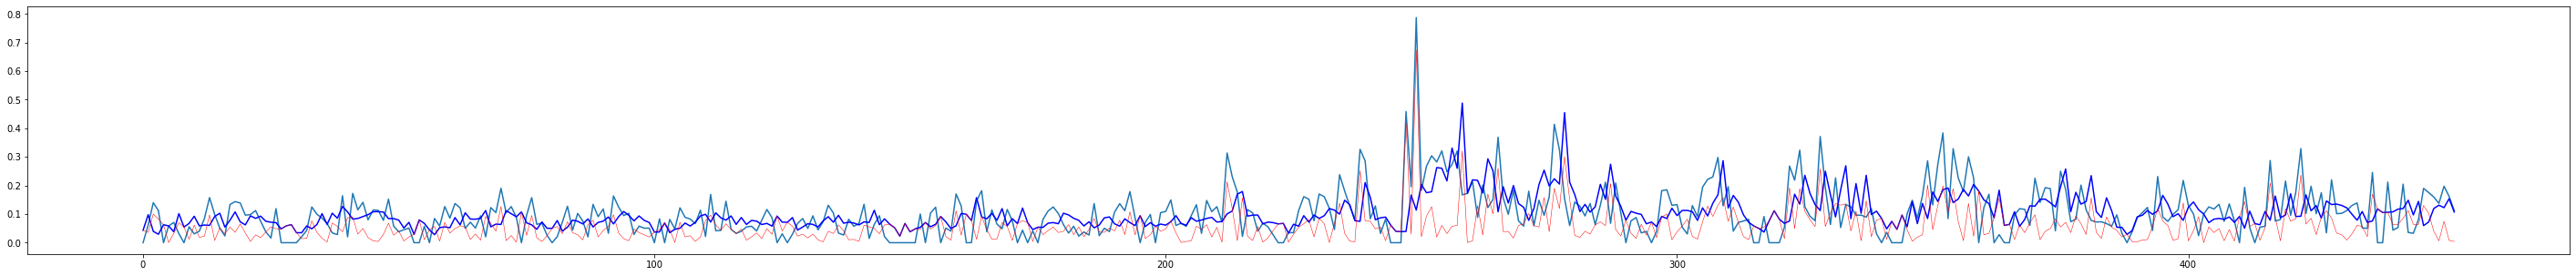

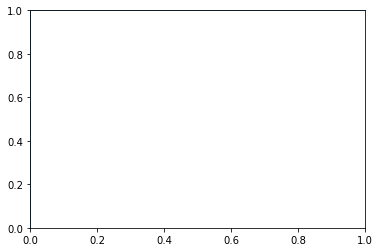

AUC:  0.9955849889624723


0.9955849889624723

In [21]:
import warnings
from sklearn.cluster import KMeans
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas import read_csv
import pandas as pd
from pandas import DataFrame
from pandas import concat
import numpy as np 
from matplotlib import pyplot
from xgboost import XGBRegressor
from sklearn import preprocessing
import sys

def warn(*args, **kwargs):
    pass
    
class XGBRegressorSliding_AnomalyDetection:
    def __init__(self,path, window_width, nu, train_rate):
        self.df = read_csv(path, header=0, index_col=0, parse_dates=True,squeeze=True)
        self.df = self.df.reset_index(drop=True)
        self.df.rename(columns={'anomaly':'is_anomaly'}, inplace=True)
        self.nu = nu
        self.window_width = window_width
        series = pd.DataFrame(self.df.iloc[:,0].values)  
        self.values = DataFrame(series.values)
        self.dataframe = concat([self.values.shift(1), self.values], axis=1)
        self.dataframe.columns = ['t', 't+1']

        self.train_size = int(len(self.values) * train_rate)

        # train_labeled, test_labeled = self.dataframe.values[1:self.train_size], self.dataframe.values[self.train_size:]
        # self.train_X, self.train_y = train_labeled[:,0], train_labeled[:,1]
        # self.test_X, self.test_y = test_labeled[:,0], test_labeled[:,1]     
        # self.create_persistence()

        # X = series.values
        # self.train, self.test = X[1:self.train_size], X[self.train_size:]    

    def __build_sets(self):
        train_labeled, test_labeled = self.dataframe.values[1:self.train_size], self.dataframe.values[self.train_size:]
        self.train_X, self.train_y = train_labeled[:,0], train_labeled[:,1]
        self.test_X, self.test_y = test_labeled[:,0], test_labeled[:,1]   

        X = self.dataframe.iloc[:,1].values
        self.train, self.test = X[1:self.train_size], X[self.train_size:]    

    def standardize_dataframe(self):
        X = self.dataframe.values
        self.scalar = preprocessing.StandardScaler().fit(X)
        X = self.scalar.transform(X)
        self.dataframe = pd.DataFrame(X)

    def inverse_standardize_dataframe(self):
        X = self.dataframe.values
        X = self.scalar.inverse_transform(X)
        self.dataframe = pd.DataFrame(X)



    def model_persistence(self, x):
        return x
        
    def create_persistence(self):
        rmse = sqrt(mean_squared_error(self.dataframe['t'].iloc[self.train_size:], self.dataframe['t+1'].iloc[self.train_size::]))
#         print('Persistent Model RMSE: %.3f' % rmse)   

    def fit(self):
        self.create_persistence()
        self.__build_sets()
                
        self.compute_anomalyOptScores()
    
    def getWindowedVectors(self, X):
        vectors = np.zeros((len(X) - self.window_width+1,self.window_width))
        for i,_ in enumerate(X[:-self.window_width+1]):
            vectors[i] = X[i:i+self.window_width]
        return vectors

    def compute_anomalyScores(self):

        xgb = XGBRegressor()
        xgb.fit(self.train_X.reshape(-1,1),self.train_y.reshape(-1,1))

        self.predictions = xgb.predict(self.test_X.reshape(-1,1))
        rmse = sqrt(mean_squared_error(self.test, self.predictions))
        self.errors = np.absolute(self.test - np.array(self.predictions))
#         print('Prediction Test RMSE: %.3f' % rmse)

   
    def compute_anomalyOptScores(self):

        warnings.warn = warn 
        # compute anomalies
        self.X = self.getWindowedVectors(self.dataframe.values[1:,0])
        self.y = self.dataframe.values[-len(self.X):,1]
        self.train_X, self.train_y= self.X[:self.train_size], self.y[:self.train_size]
        self.test_X, self.test_y = self.X[self.train_size:], self.y[self.train_size:]

        # xgb = XGBRegressor()
        # xgb.fit(self.train_X, self.train_y.reshape(-1,1))
        self.history = (self.train_X.tolist(), self.train_y.tolist())
        self.predictions = []

        for i,test_elem in enumerate(self.test_X):
            # warnings.filterwarnings("ignore")
            xgb = XGBRegressor(objective ='reg:squarederror')
            xgb.fit(self.history[0],self.history[1])
            output = xgb.predict(test_elem.reshape(1,-1))
            self.predictions.append(output[0])
            self.history[0].append(self.test_X[i])
            self.history[1].append(self.test_y[i])
            # self.history = (self.history[0].append(self.test_X[i]),self.history[1].append(self.test_y[i]))
            sys.stdout.write('\r '+str(i)+':'+str(len(self.test_X)))
        print('')

        rmse = sqrt(mean_squared_error(self.test_y, self.predictions))
        self.errors = np.absolute(self.test_y - np.array(self.predictions))
#         print('Prediction Test RMSE: %.3f' % rmse)


    def plot(self):
        # plot predicted error
        pyplot.figure(figsize=(50,5))
        pyplot.plot(self.test_y)
        pyplot.plot(self.predictions, color='blue')
        pyplot.plot(self.errors, color = 'red',  linewidth=0.5)
        pyplot.show()

    def get_roc_auc(self, plot=True, verbose=True):
        # get the predicted errors of the anomaly points
        indices = self.df[self.df['is_anomaly']==1].index >self.train_size
        true_anomaly_predicted_errors = self.errors[self.df[self.df['is_anomaly']==1].index[indices] - self.train_size - self.window_width ]
        if len(true_anomaly_predicted_errors) == 0:
            return np.nan
        # sort them 
        true_anomaly_predicted_errors = np.sort(true_anomaly_predicted_errors,axis=0).reshape(-1)
        true_anomaly_predicted_errors_extended = np.r_[np.linspace(0,true_anomaly_predicted_errors[0],40)[:-1],true_anomaly_predicted_errors]
        true_anomaly_predicted_errors_extended = np.r_[true_anomaly_predicted_errors_extended, true_anomaly_predicted_errors_extended[-1] + np.mean(true_anomaly_predicted_errors_extended)]
                # now iterate thru the predicted errors from small to big
        # for each value look how much other points have equal or bigger error
        FPR = [] # fp/n  https://en.wikipedia.org/wiki/Sensitivity_and_specificity
        TPR = [] # tp/p
        p = len(true_anomaly_predicted_errors)
        Thresholds = []
        for predictederror in true_anomaly_predicted_errors_extended:
            threshold = predictederror
            tp = len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>= threshold])
            fp = len(self.errors[self.errors>=threshold])-len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>=threshold])
            
            fpr =fp/len(self.errors)
            FPR.append(fpr)
            TPR.append(tp/p)
            if verbose:
                print("Threshold: {0:25}  - FP: {1:4} - TP: {2:4} - FPR: {3:21} - TPR: {4:4}".format(threshold,fp, tp, fpr, tp/p))

        import matplotlib.pyplot as plt
        if plot:
            plt.figure()
            plt.axis([0, 1, 0, 1])
            plt.plot(FPR,TPR)
            plt.show() 

        # This is the AUC
        from sklearn.metrics import auc
        print('AUC: ' ,auc(FPR,TPR)        )
        return auc(FPR,TPR)

xgb = XGBRegressorSliding_AnomalyDetection('Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_1.csv',30,0.7,0.66)
xgb.fit()
xgb.plot()
xgb.get_roc_auc(verbose=False)

## Evaluation

In [23]:
import os
import datetime
startTime = datetime.datetime.now()

dfs = [pd.DataFrame(columns=['filename', 'auc']), pd.DataFrame(columns=['filename', 'auc']),pd.DataFrame(columns=['filename', 'auc']),pd.DataFrame(columns=['filename', 'auc'])]
files = []
import glob
folders = ['A1Benchmark','A2Benchmark','A3Benchmark','A4Benchmark']
for j,folder in enumerate(folders):
    for i,file in enumerate(glob.glob('Univariate/YahooServiceNetworkTraffic/'+ folder + '/*.csv')):
        print(file,end=' - ')
        xgb = XGBRegressorSliding_AnomalyDetection( file, 30,0.7,0.3)
        xgb.fit()
        dfs[j].loc[i] = [os.path.basename(file),xgb.get_roc_auc(plot=False,verbose=False)]
        
endTime = datetime.datetime.now()
diff = endTime - startTime
print('Time: ',diff.seconds)

 963:964te/YahooServiceNetworkTraffic/A1Benchmark\real_1.csv - 
AUC:  0.9979253112033194
 977:978te/YahooServiceNetworkTraffic/A1Benchmark\real_10.csv - 
AUC:  0.7965628441088564
 977:978te/YahooServiceNetworkTraffic/A1Benchmark\real_11.csv - 
AUC:  0.9805725971370143
 977:978te/YahooServiceNetworkTraffic/A1Benchmark\real_12.csv - 
AUC:  0.9979550102249488
 977:978te/YahooServiceNetworkTraffic/A1Benchmark\real_13.csv - 
AUC:  0.9889229720518065
 977:978te/YahooServiceNetworkTraffic/A1Benchmark\real_14.csv - 
 977:978te/YahooServiceNetworkTraffic/A1Benchmark\real_15.csv - 
AUC:  0.9841513292433538
 992:993te/YahooServiceNetworkTraffic/A1Benchmark\real_16.csv - 
AUC:  0.9959718026183284
 966:967te/YahooServiceNetworkTraffic/A1Benchmark\real_17.csv - 
AUC:  0.652262549599333
 992:993te/YahooServiceNetworkTraffic/A1Benchmark\real_18.csv - 
 966:967te/YahooServiceNetworkTraffic/A1Benchmark\real_19.csv - 
AUC:  0.672503177546251
 977:978te/YahooServiceNetworkTraffic/A1Benchmark\real_2.csv - 

 964:965te/YahooServiceNetworkTraffic/A2Benchmark\synthetic_31.csv - 
AUC:  0.9958549222797928
 964:965te/YahooServiceNetworkTraffic/A2Benchmark\synthetic_32.csv - 
AUC:  0.9888313183649972
 964:965te/YahooServiceNetworkTraffic/A2Benchmark\synthetic_33.csv - 
AUC:  0.9989637305699481
 964:965te/YahooServiceNetworkTraffic/A2Benchmark\synthetic_34.csv - 
AUC:  0.9953367875647668
 964:965te/YahooServiceNetworkTraffic/A2Benchmark\synthetic_35.csv - 
AUC:  0.9859527921704089
 964:965te/YahooServiceNetworkTraffic/A2Benchmark\synthetic_36.csv - 
AUC:  0.9984455958549223
 964:965te/YahooServiceNetworkTraffic/A2Benchmark\synthetic_37.csv - 
AUC:  0.9958549222797929
 964:965te/YahooServiceNetworkTraffic/A2Benchmark\synthetic_38.csv - 
AUC:  0.9862982153137593
 964:965te/YahooServiceNetworkTraffic/A2Benchmark\synthetic_39.csv - 
AUC:  0.9989637305699481
 964:965te/YahooServiceNetworkTraffic/A2Benchmark\synthetic_4.csv - 
AUC:  0.8720207253886011
 964:965te/YahooServiceNetworkTraffic/A2Benchmark\s

 1145:1146/YahooServiceNetworkTraffic/A3Benchmark\A3Benchmark-TS19.csv - 
AUC:  0.993891797556719
 1145:1146/YahooServiceNetworkTraffic/A3Benchmark\A3Benchmark-TS2.csv - 
AUC:  0.9870044876589379
 1145:1146/YahooServiceNetworkTraffic/A3Benchmark\A3Benchmark-TS20.csv - 
AUC:  0.9936424831712789
 1145:1146/YahooServiceNetworkTraffic/A3Benchmark\A3Benchmark-TS21.csv - 
AUC:  0.992049641264301
 1145:1146/YahooServiceNetworkTraffic/A3Benchmark\A3Benchmark-TS22.csv - 
AUC:  0.9962914485165795
 1145:1146/YahooServiceNetworkTraffic/A3Benchmark\A3Benchmark-TS23.csv - 
AUC:  0.9895287958115183
 1145:1146/YahooServiceNetworkTraffic/A3Benchmark\A3Benchmark-TS24.csv - 
AUC:  0.9947643979057592
 1145:1146/YahooServiceNetworkTraffic/A3Benchmark\A3Benchmark-TS25.csv - 
AUC:  0.9982547993019197
 1145:1146/YahooServiceNetworkTraffic/A3Benchmark\A3Benchmark-TS26.csv - 
AUC:  0.9936424831712789
 1145:1146/YahooServiceNetworkTraffic/A3Benchmark\A3Benchmark-TS27.csv - 
AUC:  0.9947643979057592
 1145:1146/Ya

 1145:1146/YahooServiceNetworkTraffic/A3Benchmark\A3Benchmark-TS94.csv - 
AUC:  0.9966550319953462
 1145:1146/YahooServiceNetworkTraffic/A3Benchmark\A3Benchmark-TS95.csv - 
AUC:  0.9653868528214078
 1145:1146/YahooServiceNetworkTraffic/A3Benchmark\A3Benchmark-TS96.csv - 
AUC:  0.9953752181500874
 1145:1146/YahooServiceNetworkTraffic/A3Benchmark\A3Benchmark-TS97.csv - 
AUC:  0.9857766143106458
 1145:1146/YahooServiceNetworkTraffic/A3Benchmark\A3Benchmark-TS98.csv - 
AUC:  0.9475470234632538
 1145:1146/YahooServiceNetworkTraffic/A3Benchmark\A3Benchmark-TS99.csv - 
AUC:  0.9919284467713787
 1145:1146/YahooServiceNetworkTraffic/A4Benchmark\A4Benchmark-TS1.csv - 
AUC:  0.9906922629435718
 1145:1146/YahooServiceNetworkTraffic/A4Benchmark\A4Benchmark-TS10.csv - 
AUC:  0.9965095986038395
 1145:1146/YahooServiceNetworkTraffic/A4Benchmark\A4Benchmark-TS100.csv - 
AUC:  0.9954188481675393
 1145:1146/YahooServiceNetworkTraffic/A4Benchmark\A4Benchmark-TS11.csv - 
AUC:  0.980453752181501
 1145:1146/

 1145:1146/YahooServiceNetworkTraffic/A4Benchmark\A4Benchmark-TS79.csv - 
AUC:  0.9871291448516579
 1145:1146/YahooServiceNetworkTraffic/A4Benchmark\A4Benchmark-TS8.csv - 
AUC:  0.9860383944153576
 1145:1146/YahooServiceNetworkTraffic/A4Benchmark\A4Benchmark-TS80.csv - 
AUC:  0.9251987589683924
 1145:1146/YahooServiceNetworkTraffic/A4Benchmark\A4Benchmark-TS81.csv - 
AUC:  0.9944735311227458
 1145:1146/YahooServiceNetworkTraffic/A4Benchmark\A4Benchmark-TS82.csv - 
AUC:  0.9355911867364747
 1145:1146/YahooServiceNetworkTraffic/A4Benchmark\A4Benchmark-TS83.csv - 
AUC:  0.9947643979057591
 1145:1146/YahooServiceNetworkTraffic/A4Benchmark\A4Benchmark-TS84.csv - 
AUC:  0.9722949389179756
 1145:1146/YahooServiceNetworkTraffic/A4Benchmark\A4Benchmark-TS85.csv - 
AUC:  0.9801315612833937
 1145:1146/YahooServiceNetworkTraffic/A4Benchmark\A4Benchmark-TS86.csv - 
AUC:  0.9872018615474113
 1145:1146/YahooServiceNetworkTraffic/A4Benchmark\A4Benchmark-TS87.csv - 
AUC:  0.9991273996509599
 1145:1146/

### Results for UD1 - UD4

In [24]:
print(dfs[0].describe())
print(dfs[1].describe())
print(dfs[2].describe())
print(dfs[3].describe())

             auc
count  59.000000
mean    0.869522
std     0.210411
min     0.171356
25%     0.831157
50%     0.972686
75%     0.990025
max     0.998993
              auc
count  100.000000
mean     0.983792
std      0.029401
min      0.808405
25%      0.984542
50%      0.995596
75%      0.998964
max      0.998964
             auc
count  99.000000
mean    0.987954
std     0.022607
min     0.801483
25%     0.990382
50%     0.993642
75%     0.996128
max     0.999127
             auc
count  98.000000
mean    0.978157
std     0.037135
min     0.752182
25%     0.980212
50%     0.991638
75%     0.996510
max     0.999127
